## Finding the ground state of a molecule via VQE

Based on example from https://github.com/qiskit-community/qiskit-nature-pyscf

In this notebook, we investigate the ground-state electronic structure of the lithium hydride (LiH) molecule using both classical and quantum computational methods. Traditional quantum chemistry approaches, such as the Hartree-Fock (HF) and Full Configuration Interaction (FCI) methods, provide accurate results for this small molecule, but quickly become too computationally expensive as the number of orbitals increases for larger molecules. To explore the potential of quantum computing in this domain, we employ the Variational Quantum Eigensolver (VQE) with a Unitary Coupled Cluster (UCCSD) ansatz, using Qiskit. By comparing the computed ground-state energies from HF, FCI, and VQE across different bond lengths, we assess the accuracy and feasibility of hybrid quantum-classical simulations for molecular electronic structure problems.

In [ ]:
from pyscf import gto, scf, mcscf, fci # pyscf = (classical) python-based simulations of chemistry framework

# gto.M defines molecular geometry & basis set
# scf.RHF restricted Hartree-Fock
# mcscf.CASCI complete active space configuration interaction

import numpy as np
import matplotlib.pyplot as plt

from qiskit.primitives import Estimator # expectation values
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit.visualization import circuit_drawer # to show vqe circuit

from qiskit_nature_pyscf import QiskitSolver

We import two mappers, giving us two different ways to convert the electronic structure of a molecule from a fermionic problem to a qubit problem.
1. Jordan-Wigner Mapper: Simple, intuitive
    - 1 spin orbital $\rightarrow$ 1 qubit
    - unoccupied $\rightarrow\ket{0}$; occupied $\rightarrow\ket{1}$
    - spin down $\rightarrow\ket{0}$; spin up $\rightarrow\ket{1}$

2. Parity Mapper: Can reduce number of qubits required in certain cases
    - the Parity Mapper transforms the problem into global parity information instead of directly encoding individual occupation numbers
    - each qubit stores the total parity of all previous orbitals.



In [4]:
def create_molecule(bond_length):
    """ Function to create a LiH molecule given a bond length"""
    return gto.M(
        atom=f"Li 0 0 0; H 0 0 {bond_length}", basis="sto-3g"
    ) 

In [5]:
# LiH molecule created with STO-3G basis set
# Li positioned at (0,0,0), H at (0,0,1.6) atomic units
mol = create_molecule(1.6)

- Li: $1s^12s^12p^0$
- H:  $1s^1$
- The inner 1s orbital of Li is frozen, i.e. these two electrons are paired as $\ket{\uparrow\downarrow}$. We do not include these in the simulation, to reduce the number of qubits required.
- For the five spatial orbitals that we are including in our simulation ($1\times$ Li 2s, $3\times$  Li 2p and $1\times$ H 1s) we need two qubits each, one to represent occupied/unoccupied and one to encode spin up/down
- In total: 10 qubits

In [ ]:
# Define constants
norb = 5 # Number of active orbitals
nalpha, nbeta = 1, 1 # One alpha (spin up) and one beta (spin down) electron
nelec = nalpha + nbeta # Two valence electrons total

In [7]:
# runs Restricted Hartree-Fock to get molecular orbitals and reference (HF) energy (from mean-field approx)
h_f = scf.RHF(mol).run()
energy_hf = h_f.e_tot

converged SCF energy = -7.86186476980865


In [ ]:
def run_vqe(h_f):
    """
    Prepare a quantum computing-based method to solve the electronic structure problem.

    Parameters
    ----------
    h_f : HartreeFock
        The initial guess for the electronic structure.

    Returns
    -------
    total_energy : float
        The total energy of the system calculated by the CASCI method. This value 
        includes the electron correlation effects within a predefined active space 
        of orbitals.
    
    ansatz : UCCSD
        The quantum circuit ansatz (final version after parameter optimization) 
        used in the VQE algorithm.

    vqe : VQE
        The VQE optimizer object, which contains the optimized parameters used 
        in the ansatz.

    Notes
    -----
    The total energy (`cas.e_tot`) is computed using the Complete Active Space 
    Configuration Interaction (CASCI) method. CASCI selects a set of active 
    orbitals and performs a configuration interaction calculation to account for 
    electron correlation within the active space.

    The optimized ansatz is obtained after running the VQE algorithm, which minimizes 
    the energy of the quantum state described by the UCCSD ansatz.
    """
    mapper = JordanWignerMapper()
    #mapper = ParityMapper(num_particles=(nalpha, nbeta))
    # maps the fermionic Hamiltonian to a qubit Hamiltonian
    # dual of Jordan-Wigner mapping
    # allows to reduce no. of qubits in certain cases
    
    ansatz = UCCSD( # Unitary Coupled Cluster with Single and Double excitations (trial wavefunction)
        norb,
        (nalpha, nbeta),
        mapper,
        initial_state=HartreeFock(
            norb,
            (nalpha, nbeta),
            mapper,
        ),
    )
    # list of predefined  ansatzes: https://qiskit-community.github.io/qiskit-nature/apidocs/qiskit_nature.second_q.circuit.library.html
    
    vqe = VQE(Estimator(), ansatz, SLSQP()) 
    # to minimise the ground-state energy using classical Sequential Least Squares Programming optimisation
    # list of optimizers: https://qiskit-community.github.io/qiskit-algorithms/apidocs/qiskit_algorithms.optimizers.html
    
    vqe.initial_point = np.zeros(ansatz.num_parameters)
    
    algorithm = GroundStateEigensolver(mapper, vqe)

    cas = mcscf.CASCI(h_f, norb, nelec) # selects active orbitals and electrons
    cas.fcisolver = QiskitSolver(algorithm)
    #replaces the default FCI solver in PySCF with the VQE-based quantum solver
    
    cas.run()
    return cas.e_tot, ansatz

In [8]:
energy_vqe, ansatz = run_vqe(h_f)

/var/folders/x9/wfb287qn00v442vdfjd74t680000gq/T/ipykernel_2419/742531211.py:53: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe = VQE(Estimator(), ansatz, SLSQP())


CASCI E = -7.88209648959531  E(CI) = -1.07808419129326


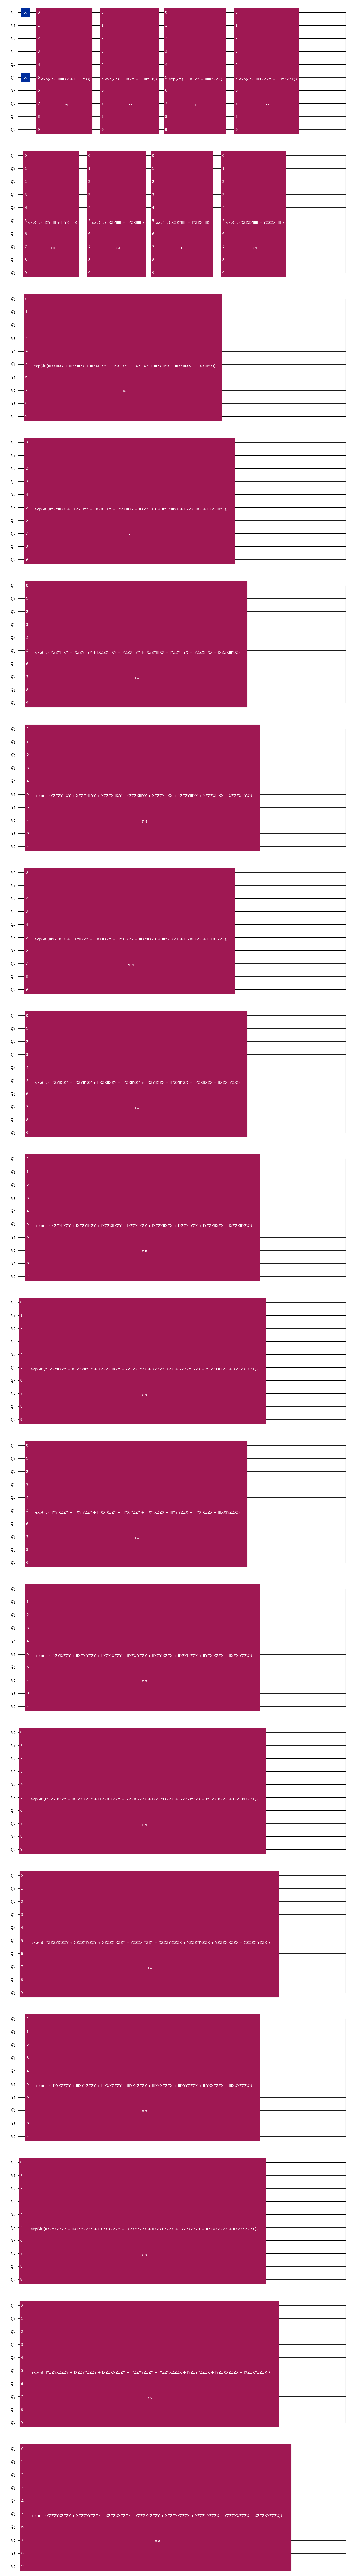

In [9]:
ansatz.decompose().draw(output="mpl")

Points to note:
- 10 qubits
- start with bit flips (X)
- then exponent of Pauli gates (I,X,Y,Z) parameterised by t[j]
- t[j] are the VQE parameters that are optimised during the algorithm


We want to compare our solution from the quantum algorithm (VQE) with the best classical solution. FCI (Full Configuration Interaction) provides a numerically exact solution for the ground state by solving the electronic Schrödinger equation. This is acheieved by fully diagonalizing the Hamiltonian in the complete active space of Slater determinants. This approach however is very computationally expensive — scaling exponentially with the system size. FCI is only possible for small single atoms or very small molecules with ~12 electrons or fewer.

In [10]:
def run_fci(h_f):
    """run a fci calculation for a benchmark"""
    cisolver = fci.FCI(h_f)
    cisolver = cisolver.run()
    return cisolver.e_tot

In [11]:
energy_fci = run_fci(h_f)

In [12]:
# Comparison of methods
print("VQE Energy:", energy_vqe)
print("FCI Energy:", energy_fci)

VQE Energy: -7.882096489595305
FCI Energy: -7.882324378883491


## Output

Converged SCF energy = Hartree-Fock energy, in Hartrees, from mean-field approximation, ignoring electron correlation.

CASCI E = Complete Active Space Configuration Interaction (CASCI) energy.
CASCI improves upon HF by allowing a full CI expansion within the active space (selected orbitals/electrons).
Since CASCI includes static correlation effects, it should always be lower (more negative) than the SCF energy.

## Bond stretching workflow

In [19]:
bond_lengths = np.linspace(1.4, 1.7, 3)

h_f_energies = []
vqe_energies = []
fci_energies = []

for bond_length in bond_lengths:
    mol = create_molecule(bond_length)
    h_f = scf.RHF(mol).run()
    h_f_energies.append(h_f.e_tot)
    vqe_energies.append(energy_vqe)
    fci_energies.append(run_fci(h_f))
    

converged SCF energy = -7.86053866102113
converged SCF energy = -7.86307516130408
converged SCF energy = -7.85714496020382


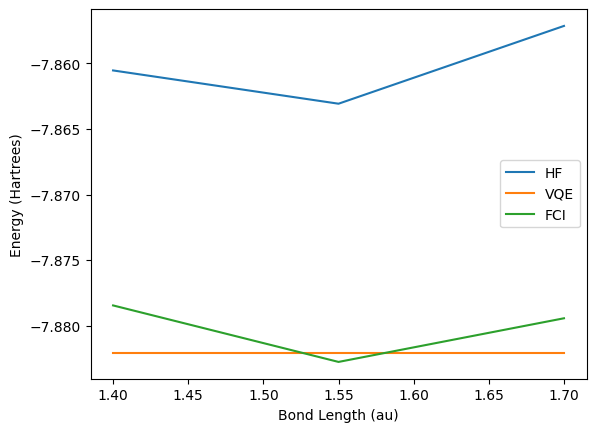

In [20]:
plt.plot(bond_lengths, h_f_energies, label="HF")
plt.plot(bond_lengths, vqe_energies, label="VQE")
plt.plot(bond_lengths, fci_energies, label="FCI")
plt.xlabel("Bond Length (au)")
plt.ylabel("Energy (Hartrees)")
plt.legend()
plt.show()